# Assignment #1 - Airline Passenger Prediction using Kaggle Data

### LT8 - Gavin Cua, Ron Lao, Alyssa Valerio, Allan Tan

In this notebook, we will predict airline passenger count with seasonality using the international airline passengers data from January 1949 to December 1960 here: 

[https://www.kaggle.com/datasets/andreazzini/international-airline-passengers](https://www.kaggle.com/datasets/andreazzini/international-airline-passengers)

The following activity will be performed:

(1) Forecast using ARIMA the last twelve months (1 year, January-December 1960) with the most optimal choice of p,d,q [10 pts]

(2) Compare the results' RMSE, MAE, and run time with XGBoost. [10 pts]


### Step 1: Lets load the dataset

In [1]:
# separate out a validation dataset
from pandas import read_csv

# Load the series without 'squeeze' parameter
series = read_csv('international-airline-passengers.csv', header=0, index_col=0, parse_dates=True)

# change column name to 'Passengers'
series.columns = ['Passengers']

# remove the last 2 lines as they are NaN
series = series.iloc[:-2]

# Split the data into training (dataset) and validation sets
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]

# Display dataset and validation sizes
print(f'Dataset {len(dataset)}, Validation {len(validation)}')

# Save the datasets to CSV
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)


Dataset 131, Validation 12


### Step 2: Plot the time series to visualize the behaviour

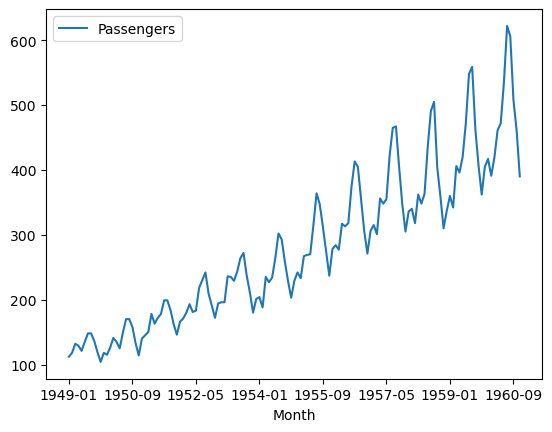

In [2]:
from matplotlib import pyplot
%matplotlib inline
series.plot()
pyplot.show()

We can see that the number of passengers increases over time, with a seasonal pattern that repeats every year.
However, the variance of the number of passengers seems to be increasing over time.

### Step 3: Let's do a walk-forward validation to establish a baseline

In [3]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

RMSE: 43.355
MAE: 35.569


The RMSE (**43.355**) or MAE (**35.569**) computed from 1 step time ahead is like the proportional chance criterion ratio for time series forecasting. We must beat the accuracy of prediction that assumes the next **"time step is just equal to the current time step"**.

### Step #4: Let's check basic statistics of the dataset

In [5]:
from pandas import read_csv

# Read the CSV file
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True)

# If the result is a single-column DataFrame, squeeze it to convert it into a Series
series = series.squeeze()

# Print descriptive statistics
print(series.describe())


count    131.000000
mean     261.404580
std      106.297245
min      104.000000
25%      175.000000
50%      237.000000
75%      341.000000
max      559.000000
Name: 1, dtype: float64


Note that the MAE (**35.369**) in the previous walk in validation step is lower than the standard deviation (**106.297**) implying that such a simple rule is giving sensible a prediction.

### Step 5: Let's check the Seasonal Line Plots to confirm yearly seasonality.

/tmp/ipykernel_8657/1042831294.py:8: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  groups = series['1949':'1959'].groupby(Grouper(freq='A'))


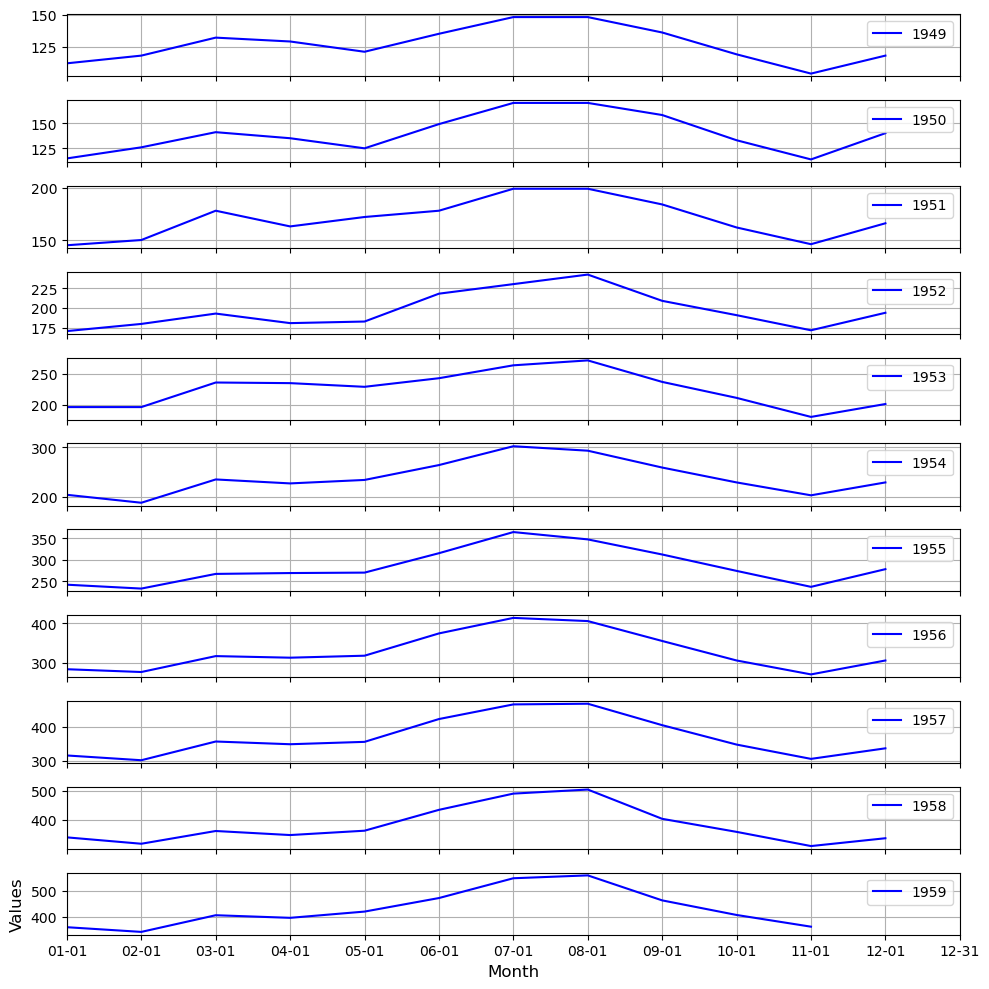

In [6]:
from pandas import read_csv, DataFrame, Grouper
from matplotlib import pyplot as plt

# Load the dataset and squeeze the single column to a series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()

# Group the series data by year ('A' stands for annual frequency)
groups = series['1949':'1959'].groupby(Grouper(freq='A'))

# Initialize the plotting area, making sure to accommodate each group
fig, axs = plt.subplots(len(groups), 1, figsize=(10, 10), sharex=True)

# Loop over each group to plot separately
for i, (name, group) in enumerate(groups):
    # Extract the year to align each subplot from Jan to Dec
    group.index = group.index.strftime('%m-%d')  # Format index to show only the month and day

    axs[i].plot(group.index, group.values, label=f'{name.year}', color='b')
    axs[i].set_xlim(['01-01', '12-31'])  # Set x-axis from January to December
    axs[i].legend(loc='upper right')  # Use the legend to show the year
    axs[i].grid(True)  # Add grid for better visual clarity

# Set a common x label and y label
plt.xlabel('Month', fontsize=12)
plt.ylabel('Values', fontsize=12)

# Adjust layout to prevent overlap and ensure legends and axis labels are clean
plt.tight_layout()

# Show the plot
plt.show()


Running the example creates the stack of several line plots. We can clearly see a peak every July, August and a dip from Nov to Feb next year. This pattern appears the same each year, although at different levels.

This will help with any explicitly season-based modeling later.

### Step #6: Now, lets do a Density Plot and see if we can extract any additional insights from the data

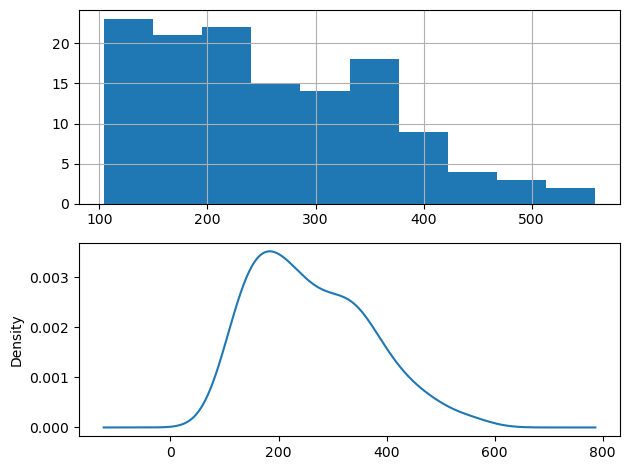

In [7]:
from pandas import read_csv
from matplotlib import pyplot as plt

# Load the data without the deprecated 'squeeze' argument and use .squeeze() afterward
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()

# Create the figure for subplots
plt.figure(1)

# Create the histogram in the first subplot
plt.subplot(211) # 211 is the format for 2 rows, 1 column, 1st subplot
series.hist()

# Create the kernel density estimate (KDE) plot in the second subplot
plt.subplot(212)
series.plot(kind='kde')

# Show the plot
plt.tight_layout()  # Ensures that the subplots don't overlap
plt.show()


Some observations from the plots include:

--- The distribution is not Gaussian.

--- The distribution has 2 peaks suggesting bi-modal distribution. This could indicate presence of 2 clusters or modes in the data.

--- The shape has a long right tail and may suggest an presence of higher order values that affect the overall distribution.

### Step 7: Visualize with  Box and Whisker Plots

/tmp/ipykernel_8657/3850308823.py:8: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  groups = series['1949':'1958'].groupby(Grouper(freq='A'))


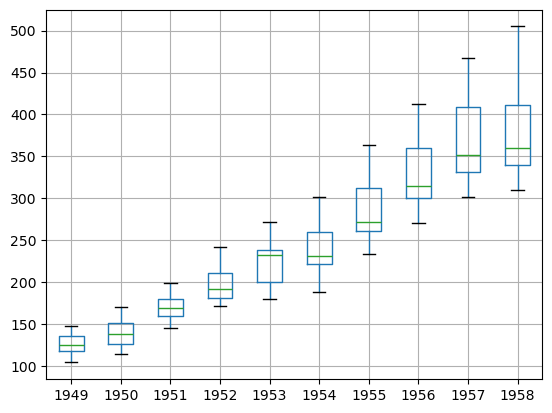

In [18]:
from pandas import read_csv, DataFrame, Grouper
from matplotlib import pyplot as plt

# Load the dataset, use .squeeze() after loading to convert to Series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()

# Group the series data by year ('A' stands for annual frequency)
groups = series['1949':'1958'].groupby(Grouper(freq='A'))

# Create an empty DataFrame to store yearly data
years = DataFrame()

# Loop through each group and store the values in the 'years' DataFrame
for name, group in groups:
    years[name.year] = group.values

# Plot a boxplot for each year
years.boxplot()

# Show the plot
plt.show()


Some observations from reviewing the plots include:  

**Increasing Trend.** The median values for each year (green line) clearly shows an increasing trend. This suggests that the values are generally increasing from year to year.

**Increasing Variance.** The length of the whiskers is increasing over the years. This indicates greater variability in the data over time, meaning that the spread of the values is getting larger. Interestingly, the increase in spread seems proportional to increase in median values.

**No Outliers.** There are no outliers shown (circle dots outside the whiskers).

In summary, the plot indicates an increasing trend in the data over time with linearly increasing variability.

### Step #8: Let's check the stationarity as this is critical.


In [9]:
from statsmodels.tsa.stattools import adfuller
from pandas import read_csv, Series

# Load the dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()

# Convert the series values to float32
X = series.values
X = X.astype('float32')

# Create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# Difference data
months_in_year = 12
stationary = difference(X, months_in_year)

# Set the index of the stationary series to align with the original series
stationary.index = series.index[months_in_year:]

# Perform the ADF test to check stationarity
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Save the differenced data to a CSV file
stationary.to_csv('stationary.csv', header=False)

ADF Statistic: -3.393847
p-value: 0.011170
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


The results show that test statistic value of -3.39 is smaller than critical value at 5% but not at 1% (-3.48). Since the p value is 0.011, we can reject the null hypothesis at 5%. This means the time series is **likely stationary** but with some caution. 

### Step 9: Select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively using ACF and PACF.

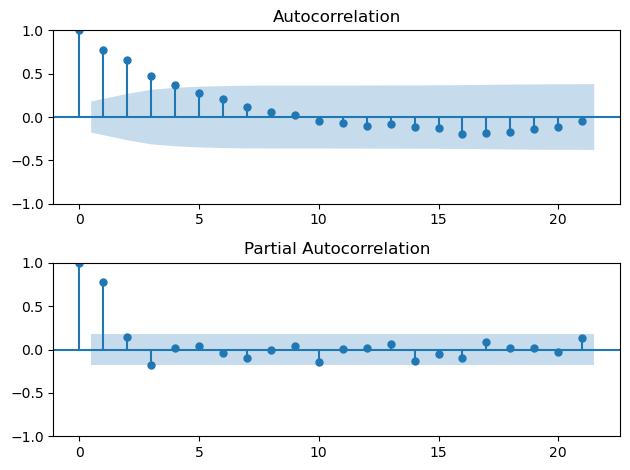

In [10]:
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt

# Load the dataset
series = read_csv('stationary.csv', header=None, index_col=0, parse_dates=True).squeeze()

# Create a figure for subplots
plt.figure()

# Plot ACF (Autocorrelation Function) in the first subplot
plt.subplot(211)
plot_acf(series, ax=plt.gca())

# Plot PACF (Partial Autocorrelation Function) in the second subplot
plt.subplot(212)
plot_pacf(series, ax=plt.gca())

# Show the plots
plt.tight_layout()  # Ensure no overlapping between plots
plt.show()


In [11]:
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

#def difference(dataset, interval=1):
#    diff = np.diff(dataset, n=interval)
#    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = dataset
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
	# difference data
  months_in_year = 12
  diff = difference(history, months_in_year)
  #predict
  model = ARIMA(diff, order=(0, 0, 0))
  model_fit = model.fit()
  #Forecast one step ahead (you can adjust the steps as needed)
  forecast = model_fit.get_forecast(steps=1)
  #Get the forecasted value
  yhat = forecast.predicted_mean[0]
  #Reverse the differencing if necessary (assuming you have the inverse_difference function)
  yhat = inverse_difference(history, yhat, months_in_year)
  #Append the forecasted value to the predictions list
  predictions.append(yhat)
  #observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# report performance
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

/tmp/ipykernel_8657/3767988643.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))


>Predicted=265.189, Expected=264
>Predicted=286.167, Expected=302
>Predicted=294.455, Expected=293
>Predicted=259.429, Expected=259
>Predicted=233.421, Expected=229
>Predicted=202.345, Expected=203
>Predicted=223.356, Expected=229
>Predicted=226.450, Expected=242
>Predicted=210.705, Expected=233
>Predicted=258.065, Expected=267
>Predicted=250.206, Expected=269
>Predicted=257.500, Expected=270
>Predicted=287.692, Expected=315
>Predicted=326.106, Expected=364
>Predicted=317.672, Expected=347
>Predicted=284.103, Expected=312
>Predicted=254.507, Expected=274
>Predicted=228.786, Expected=237
>Predicted=254.901, Expected=278
>Predicted=268.222, Expected=284
>Predicted=259.438, Expected=277
>Predicted=293.676, Expected=317
>Predicted=295.987, Expected=313
>Predicted=297.211, Expected=318
>Predicted=342.481, Expected=374
>Predicted=391.885, Expected=413
>Predicted=375.152, Expected=405
>Predicted=340.525, Expected=355
>Predicted=302.704, Expected=306
>Predicted=265.744, Expected=271
>Predicted

Running this example results in an RMSE and MAE of **18.748** and **15.899**, respectively, which is dramatically better than the 1 step walkin RMSE and MAE of 43.35 and 35.57, respectively.

### Step 10: Let's do a grid search to find optimal hyperparameters.

Specifically, we will search all combinations of the following parameters:

p: 0 to 6.
d: 0 to 2.
q: 0 to 6.
This is (7 * 3 * 7), or 147, potential runs of the test harness and will take some time to execute.

In [12]:
import warnings
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA

# Create a differenced series
def difference(dataset, interval=1):
    diff = np.diff(dataset, n=interval)
    return diff

# Invert differenced value
#def inverse_difference(history, yhat, interval=1):
#    return yhat + history[-interval]

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# Evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    #X = X.astype('float32')
    train_size = int(len(X) * 0.80)  # Use 80% of data for training
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    #history = list(train)
    months_in_year = 12  # Define the number of months in a year

    # Make predictions
    predictions = list()
    for t in range(len(test)):
        # Difference data
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=1)
        yhat = forecast.predicted_mean[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    # Calculate out-of-sample error (RMSE)
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    #print(test)
    #print(predictions)
    return rmse

In [13]:
from itertools import product
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Filter out ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

# Define ranges for p, d, q
p_range = range(0, 4)
d_range = range(0, 2)
q_range = range(0, 4)

# Initialize a dictionary to store the results
results = {}

# Iterate over all combinations of p, d, q
for p, d, q in product(p_range, d_range, q_range):
    order = (p, d, q)
    # Evaluate the ARIMA model for the current (p, d, q) order
    rmse = evaluate_arima_model(X, order)
    # Store the result in the dictionary
    results[order] = rmse
    print(f"Order {order}, RMSE: {rmse}")

# Find the (p, d, q) combination with the lowest RMSE
best_order = min(results, key=results.get)
best_rmse = results[best_order]

# Print the best (p, d, q) combination and the corresponding RMSE
print(f"\nBest Order: {best_order}, Lowest RMSE: {best_rmse}")

Order (0, 0, 0), RMSE: 19.42946446393901
Order (0, 0, 1), RMSE: 15.184461501605844
Order (0, 0, 2), RMSE: 13.208080269267525
Order (0, 0, 3), RMSE: 11.852951622199557
Order (0, 1, 0), RMSE: 12.82936437755321
Order (0, 1, 1), RMSE: 12.696549218608451
Order (0, 1, 2), RMSE: 12.808966619305876
Order (0, 1, 3), RMSE: 12.549200049206323
Order (1, 0, 0), RMSE: 12.086147077206821
Order (1, 0, 1), RMSE: 12.12115354581609
Order (1, 0, 2), RMSE: 11.711104928131048
Order (1, 0, 3), RMSE: 11.947475559347712
Order (1, 1, 0), RMSE: 12.552048012247157
Order (1, 1, 1), RMSE: 12.466452174117956
Order (1, 1, 2), RMSE: 12.564426862682408
Order (1, 1, 3), RMSE: 12.61124267360124
Order (2, 0, 0), RMSE: 12.064822274838429


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (2, 0, 1), RMSE: 12.095342171517668
Order (2, 0, 2), RMSE: 11.797110407419426
Order (2, 0, 3), RMSE: 11.94423178155726
Order (2, 1, 0), RMSE: 12.555085532543862


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (2, 1, 1), RMSE: 12.553919352667567
Order (2, 1, 2), RMSE: 12.17759450726614
Order (2, 1, 3), RMSE: 12.998481661820941
Order (3, 0, 0), RMSE: 11.82892608953326
Order (3, 0, 1), RMSE: 11.887752070597376


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order (3, 0, 2), RMSE: 11.939382035255806
Order (3, 0, 3), RMSE: 12.185796530590888
Order (3, 1, 0), RMSE: 12.687101310892555
Order (3, 1, 1), RMSE: 12.354707359760186
Order (3, 1, 2), RMSE: 12.55293539909248
Order (3, 1, 3), RMSE: 12.577668858188707

Best Order: (1, 0, 2), Lowest RMSE: 11.711104928131048


Running the example runs through all combinations and reports the results on those that converge without error. The results show that the best configuration discovered was ARIMA(1, 0, 2) with an RMSE of 11.71 lower than the manually configured ARIMA from the previous section.

### Step #11: Review Residual Errors

A good final check of a model is to review residual forecast errors.

Ideally, the distribution of residual errors should be a Gaussian with a zero mean.


               0
count  27.000000
mean   -0.112361
std    11.933643
min   -38.197021
25%    -6.799149
50%     1.850250
75%     7.933655
max    20.652893


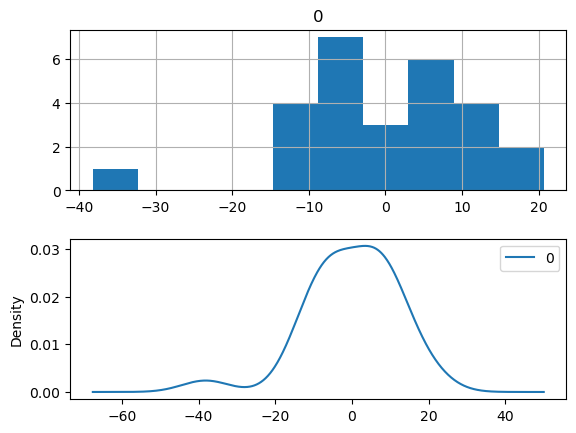

In [14]:
from pandas import read_csv
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = dataset
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1, 0, 2))
	model_fit = model.fit()
	forecast = model_fit.get_forecast(steps=1)
	#Get the forecasted value
	yhat = forecast.predicted_mean[0]
	#Reverse the differencing if necessary (assuming you have the inverse_difference function)
	yhat = inverse_difference(history, yhat, months_in_year)
  #Append the forecasted value to the predictions list
	predictions.append(yhat)

	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

Running the example first describes the distribution of the residuals. We can see that the distribution is almost mean-cented - **mean is -0.112361.** 

Let's accept this as is and proceed with prediction.

### Step #12: Make the prediction and validate the model.

>Predicted=381.543, Expected=405.000
>Predicted=419.951, Expected=417.000
>Predicted=397.654, Expected=391.000
>Predicted=450.321, Expected=419.000
>Predicted=409.434, Expected=461.000
>Predicted=466.140, Expected=472.000
>Predicted=524.103, Expected=535.000
>Predicted=603.656, Expected=622.000
>Predicted=623.475, Expected=606.000
>Predicted=511.628, Expected=508.000
>Predicted=446.064, Expected=461.000
>Predicted=408.794, Expected=390.000
RMSE: 21.656


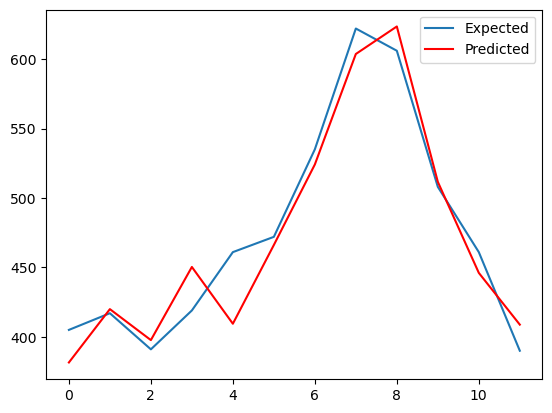

In [15]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import pickle  # Import pickle for loading the ARIMA model

# Invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# Load and prepare datasets
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()
X = series.values.astype('float32')
history = [x for x in X]
months_in_year = 12

# Load validation data
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True).squeeze()
y = validation.values.astype('float32')

# original code computes ARIMA directly from X
# model = ARIMA(X, order=(1, 0, 2))
# model_fit = model.fit()

# we need to compute based on diff
diff = difference(X, months_in_year)
model = ARIMA(diff, order=(1, 0, 2))
model_fit = model.fit()

# Make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))

# Rolling forecasts
for i in range(1, len(y)):
    # Difference the data
    diff = difference(history, months_in_year)
    # Fit the ARIMA model
    model = ARIMA(diff, order=(1,0,2))
    model_fit = model.fit()
    # Forecast
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# Report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

# Plot expected vs predicted values
pyplot.plot(y, label='Expected')
pyplot.plot(predictions, color='red', label='Predicted')
pyplot.legend()
pyplot.show()

In [16]:
import numpy as np
from sklearn.metrics import r2_score

print("R2 score = %f"%r2_score( y,predictions))

R2 score = 0.919057


Here, we used the **difference(X, months_in_year)** since we need to compute based on the difference